# HRV data 
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr> 

In [1]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('D:/ExperimentsPhD/June_19_24/wasslsp')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = 'D:/ExperimentsPhD/June_19_24/wasslsp/data/'

In [2]:
df_hr = pd.read_csv(path_data + 'HRVProcessedData[[Beat]].csv')

In [3]:
df_hr.head(), df_hr.columns, df_hr.shape

(   Unnamed: 0   Time        niHR        RR
 0           1  0.000  182.926773  328.0001
 1           2  0.328  182.926773  328.0001
 2           3  0.716  154.639375  387.9995
 3           4  1.124  147.058679  408.0004
 4           5  1.500  159.574468  376.0000,
 Index(['Unnamed: 0', 'Time', 'niHR', 'RR'], dtype='object'),
 (17178, 4))

In [4]:
df_hr['niHR_scaled'] = np.log(df_hr[['niHR']])

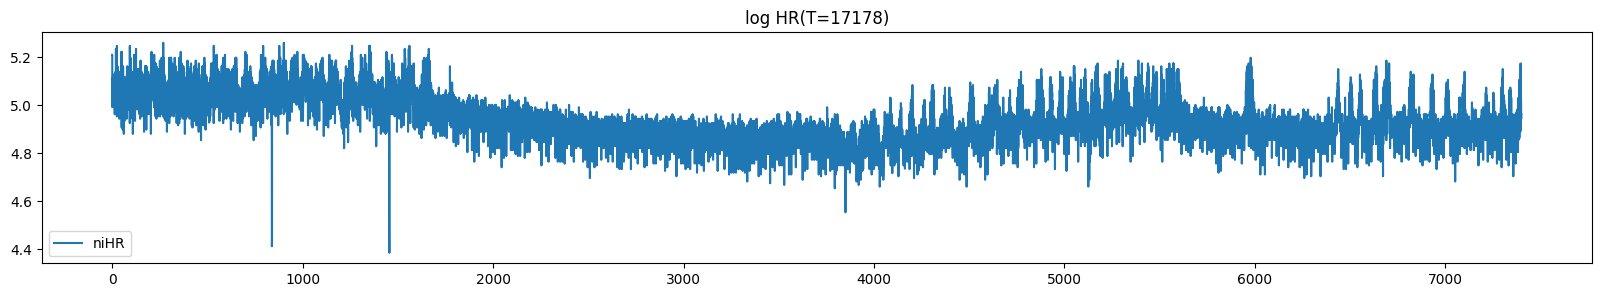

In [5]:
plt.rcParams["figure.figsize"] = (20,3)
#plt.plot(df_hr['Time'], df_hr['niHR'], label="niHR")
plt.plot(df_hr['Time'], df_hr['niHR_scaled'], label="niHR")
plt.legend()
plt.title("log HR(T=17178)")
plt.show()

In [6]:

T = df_hr.shape[0]
n_replications = 3
d = 1


X_tvar_2 = np.zeros(T)
X_tvar_2_mean = np.zeros(T)

X_tvar_2_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    sigma_star = lambda u: 0.01
    t = 1
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2[t] = df_hr['niHR_scaled'].values[t] + sigma_star(t/T) * epsilon[t]
        X[t] = [X_tvar_2[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2

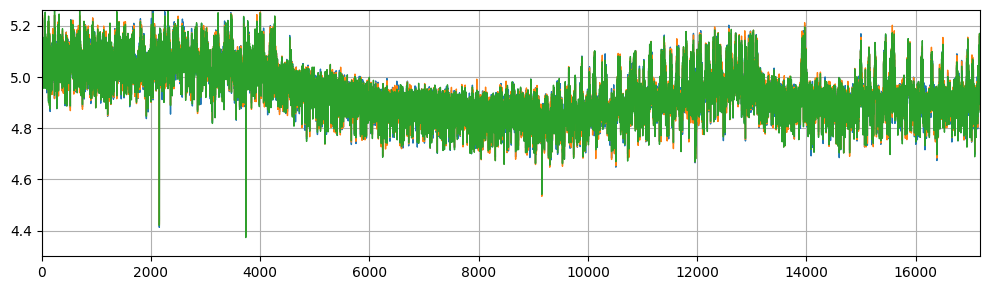

In [8]:
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1)
    plt.ylim(4.3, max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    plt.tight_layout()
    plt.grid(True)
plt.show()

In [9]:
times_t = [4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750] 
times_T = [T]
times_sigma = [10**-1, 10**-2, 10**-3, 10**-4, 10**-5]
n_replications = [3, 4, 5]
d = 1


In [10]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

for sigma_ in times_sigma:
    X_dict[f"sigma:{sigma_}"] = {}
    
    for rep in n_replications:
        X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
        X_dict[f"sigma:{sigma_}_rep:{rep}"] = {}


In [11]:
import torch
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [12]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                sigma_star = lambda u: sigma_
                t = 1
                epsilon = np.random.normal(0, sigma_, size=(T))
                X = np.zeros((T, d))
                X_tvar_2_T = np.zeros(T)
                
                while t <= T-1:
                    X_tvar_2_T[t] = df_hr['niHR_scaled'].values[t] + sigma_star(t/T) * epsilon[t]
                    X[t] = [X_tvar_2_T[t-1]]
                    t += 1

                X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication] = X_tvar_2_T
                X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)] = X


In [13]:
X_tvar_2 = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


In [14]:

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for rep in n_replications:
        for replication in range(rep):
            for sigma_ in times_sigma:
                z = X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication][t-1]
                X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(z)


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.array(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [15]:
plt.rcParams["figure.figsize"] = (5, 4)

norm_X_tvar_2 = {}
for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            norm_X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


# space_kernel = "gaussian"; time_kernel = "uniform"

In [16]:
space_kernel = "gaussian"  # "silverman"
time_kernel = "uniform"  # "tricube"
xi = 0.4 / (2 * (d + 1))
lambda_ = 1 / 12

T = df_hr.shape[0]
gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}

for sigma_ in times_sigma:
    bandwidth = lambda_ * (T ** (-xi))
    gaussian_kernel[f"sigma:{sigma_}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)


In [17]:
gaussian_kernel

{'sigma:0.1': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.01': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.001': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:0.0001': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform'),
 'sigma:1e-05': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform')}

In [18]:
for rep in n_replications:
    for replication in range(rep):
        for t in times_t:
            for sigma_ in times_sigma:
                gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = \
                gaussian_kernel[f"sigma:{sigma_}"].fit(X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)], t)


In [22]:
n_replications

[3, 4, 5]

In [19]:
gaussian_weights_tensor = {}  # Initialize the tensor dictionary

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):
        for rep in n_replications:
            gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"] = {}

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):  
        for rep in n_replications:
            for replication in range(rep):
                # Assign the corresponding gaussian weights for each replication and rep
                gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)] = \
                gaussian_weights[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)]


In [20]:
empirical_cds = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [21]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [22]:
x_rep = {} 
y_rep = {} 
wasserstein_distances = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


for rep in n_replications:
    for replication in range(rep): 
        for t in times_t:
            for sigma_ in times_sigma:
                y, x = eval_univariate(
                    X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication], 
                    gaussian_weights_tensor[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )
                
                x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = x
                y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = y
                
                distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication]))
                wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = distance


In [23]:
wass_distances_all_replications = {}


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                
                wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(
                    wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )


In [24]:
plt.rcParams["figure.figsize"] = (10, 3)
wass_distances_empirical_meanNW = {}


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            
            wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = wasserstein_distance(
                empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"], y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"].mean(axis=0)
            )


In [25]:
wass_distances_empirical_meanNW

{'t:4000_sigma:0.1_rep:3': 0.8119208529301921,
 't:4000_sigma:0.1_rep:4': 0.8119879961536882,
 't:4000_sigma:0.1_rep:5': 0.8103042204310715,
 't:4000_sigma:0.01_rep:3': 0.8125001429844882,
 't:4000_sigma:0.01_rep:4': 0.8123671947134312,
 't:4000_sigma:0.01_rep:5': 0.8121089883072148,
 't:4000_sigma:0.001_rep:3': 0.8122128420789482,
 't:4000_sigma:0.001_rep:4': 0.8122644218171893,
 't:4000_sigma:0.001_rep:5': 0.8122366445376815,
 't:4000_sigma:0.0001_rep:3': 0.8126478899102175,
 't:4000_sigma:0.0001_rep:4': 0.8122864791958941,
 't:4000_sigma:0.0001_rep:5': 0.8125413051173079,
 't:4000_sigma:1e-05_rep:3': 0.8123926410305813,
 't:4000_sigma:1e-05_rep:4': 0.812412544048154,
 't:4000_sigma:1e-05_rep:5': 0.8121436322304426,
 't:4250_sigma:0.1_rep:3': 0.8315476677841938,
 't:4250_sigma:0.1_rep:4': 0.8216570950499325,
 't:4250_sigma:0.1_rep:5': 0.825577549352698,
 't:4250_sigma:0.01_rep:3': 0.82692799607337,
 't:4250_sigma:0.01_rep:4': 0.8268029721380983,
 't:4250_sigma:0.01_rep:5': 0.82633349

In [26]:
plt.rcParams["figure.figsize"] = (10, 3)
wass_times_t = {}


for t in times_t:
    for rep in n_replications:
        wass_times_t[f"t:{t}_rep:{rep}"] = []


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            
            wass_times_t[f"t:{t}_rep:{rep}"].append(wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


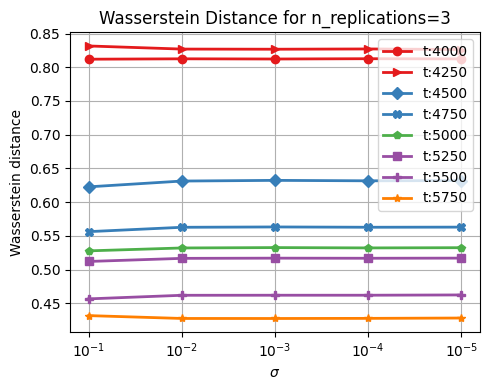

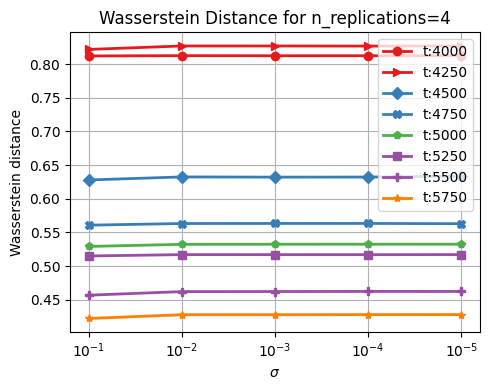

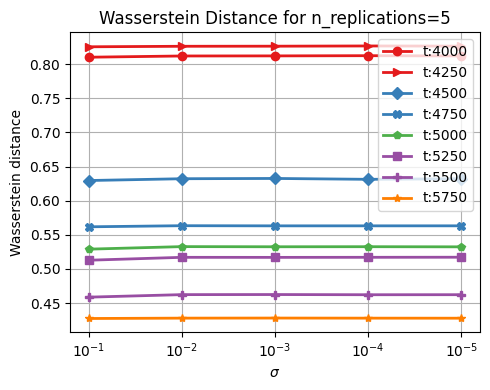

In [28]:
plt.rcParams["figure.figsize"] = (5, 4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*']
times_sigma_cat = [r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$']


for rep in n_replications:
    plt.figure()  
    for i, t in zip(range(len(times_t)), times_t):
        plt.plot(times_sigma_cat, wass_times_t[f"t:{t}_rep:{rep}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    
    #plt.ylim(0.17, 0.4)
    plt.xlabel(r'$\sigma$')
    plt.ylabel("Wasserstein distance")
    plt.title(f"Wasserstein Distance for n_replications={rep}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    
    # plt.savefig(f"wass_distance_{rep}.png", dpi=150)
    
    plt.show()  
